In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU') 

2023-10-22 18:33:38.559725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
%pip install pillow
import sys
from PIL import Image
sys.modules['Image'] = Image 
%pip install scipy
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = .2)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = .2)

training_set = train_datagen.flow_from_directory('/work/networks/sriram88/DATA',
                                       target_size=(300, 300),
                                                batch_size=32,
                                     class_mode='categorical',
                                            subset='training')

validation_set = test_datagen.flow_from_directory('/work/networks/sriram88/DATA',
                                        target_size=(300, 300),
                                                 batch_size=32,
                                      class_mode='categorical',
                                               shuffle = False,
                                           subset='validation')

Found 2580 images belonging to 2 classes.
Found 644 images belonging to 2 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
##model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(300,300,3)))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(2, activation='softmax'))
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

2023-10-22 18:33:44.764718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 18:33:46.220561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30952 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 296, 296, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 148, 148, 64)      0         
                                                                 
 flatten (Flatten)           (None, 1401856)           0         
                                                                 
 dense (Dense)               (None, 128)               179437696 
                                                        

In [6]:
checkpoint = ModelCheckpoint("cnn.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
#model training
model.fit(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=50,
                    batch_size =128,
                    validation_data=validation_set,
                    callbacks=[checkpoint,early],
                    validation_steps = len(validation_set))

Epoch 1/50


2023-10-22 18:33:51.149500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-10-22 18:33:52.626271: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-22 18:33:52.626601: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-22 18:33:52.626631: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-22 18:33:52.627082: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-22 18:33:52.627124: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


81/81 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.5857
Epoch 1: val_accuracy improved from -inf to 0.60559, saving model to cnn.h5
81/81 [==============================] - 127s 2s/step - loss: 0.6615 - accuracy: 0.5857 - val_loss: 0.5897 - val_accuracy: 0.6056
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.6787
Epoch 2: val_accuracy improved from 0.60559 to 0.88199, saving model to cnn.h5
81/81 [==============================] - 82s 1s/step - loss: 0.6122 - accuracy: 0.6787 - val_loss: 0.4821 - val_accuracy: 0.8820
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.7171
Epoch 3: val_accuracy did not improve from 0.88199
81/81 [==============================] - 77s 954ms/step - loss: 0.5746 - accuracy: 0.7171 - val_loss: 0.4523 - val_accuracy: 0.7950
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.7450
Epoch 4: val_accuracy did not improve 

In [7]:
%pip install scikit-learn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix for CNN')
cm=confusion_matrix(validation_set.classes, y_pred)
print('Classification Report')
target_names = ['NH4CL', 'Others']
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Confusion Matrix for CNN
Classification Report
              precision    recall  f1-score   support

       NH4CL       0.97      1.00      0.98       313
      Others       1.00      0.97      0.98       331

    accuracy                           0.98       644
   macro avg       0.98      0.98      0.98       644
weighted avg       0.98      0.98      0.98       644



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


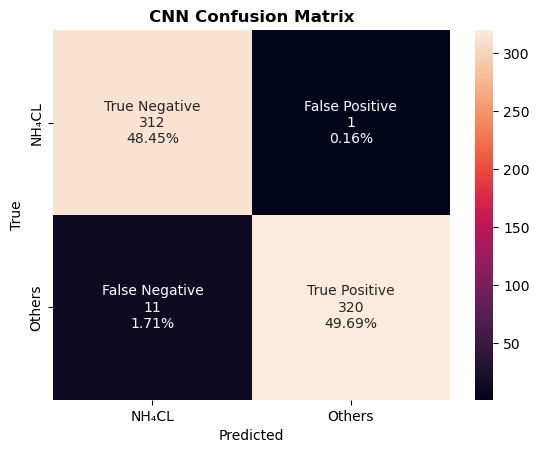

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%pip install seaborn
import seaborn as sns
labels = ['NH\u2084CL', "Others",]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# sns.heatmap(cm, annot=True)
# disp.plot(cmap=plt.cm.Blues)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.title('CNN Confusion Matrix')

# plt.savefig('cnn.png')

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
label = ['NH\u2084CL', "Others",]
sns.heatmap(cm, annot=labels, fmt='',xticklabels=label, yticklabels=label)
plt.title('CNN Confusion Matrix',fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('cnn.png')
plt.show()

21/21 [==============================] - 11s 497ms/step


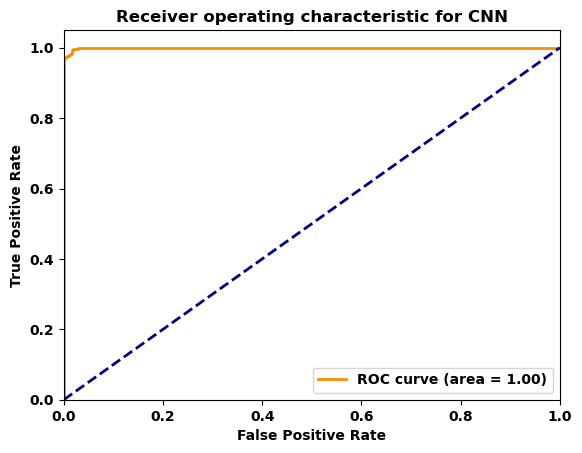

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
model.evaluate(validation_set)



STEP_SIZE_TEST=validation_set.n//validation_set.batch_size
validation_set.reset()
preds=model.predict(validation_set)
preds

fpr, tpr, _ = roc_curve(validation_set.classes,  preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN',fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('RocCNN.png')
plt.show()


In [10]:
import tensorflow as tf
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False
)

x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
predictions = tf.keras.layers.Dense(
    int(len(training_set.class_indices.keys())),
    activation='softmax'
)(x)

resnet50_model = tf.keras.models.Model(
    inputs= resnet_model.input, 
    outputs=predictions
)

checkpoint = ModelCheckpoint("resnet50.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
resnet50_model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    metrics=['accuracy']
)

resnet_history = resnet50_model.fit_generator(
    training_set, 
    epochs=50, 
    shuffle=True, 
    verbose=1,
    validation_data=validation_set,
    callbacks=[checkpoint,early]
)

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8539
Epoch 1: val_accuracy improved from -inf to 0.51398, saving model to resnet50.h5
81/81 [==============================] - 86s 980ms/step - loss: 0.3883 - accuracy: 0.8539 - val_loss: 1.1056 - val_accuracy: 0.5140
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9872
Epoch 2: val_accuracy did not improve from 0.51398
81/81 [==============================] - 77s 953ms/step - loss: 0.1098 - accuracy: 0.9872 - val_loss: 2.4639 - val_accuracy: 0.5140
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9911
Epoch 3: val_accuracy did not improve from 0.51398
81/81 [==============================] - 78s 958ms/step - loss: 0.0633 - accuracy: 0.9911 - val_loss: 3.2933 - val_accuracy: 0.5140
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9915
Epoch 4: val_accuracy did not improve from 0.

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = resnet50_model.predict_generator(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_set.classes, y_pred)
print('Classification Report')
target_names = ['NH4CL', 'Others']
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       NH4CL       1.00      1.00      1.00       313
      Others       1.00      1.00      1.00       331

    accuracy                           1.00       644
   macro avg       1.00      1.00      1.00       644
weighted avg       1.00      1.00      1.00       644



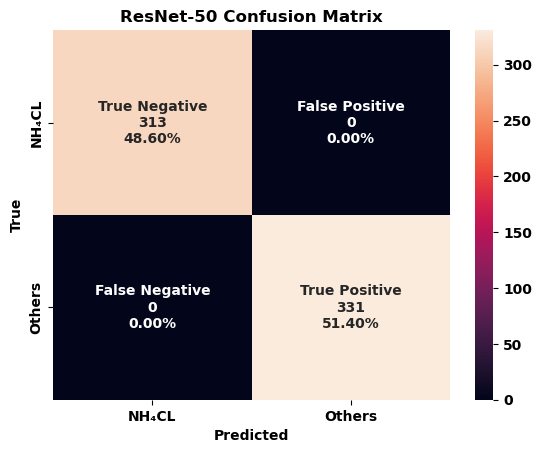

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
labels = ['NH\u2084CL', "Others",]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


# sns.heatmap(cm, annot=True)
# disp.plot(cmap=plt.cm.Blues)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.title('CNN Confusion Matrix')

# plt.savefig('cnn.png')

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
label=['NH\u2084CL', "Others",]
sns.heatmap(cm, annot=labels, fmt='',xticklabels=label, yticklabels=label)
plt.title('ResNet-50 Confusion Matrix',fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('resnet50.png')
plt.show()

21/21 [==============================] - 11s 514ms/step


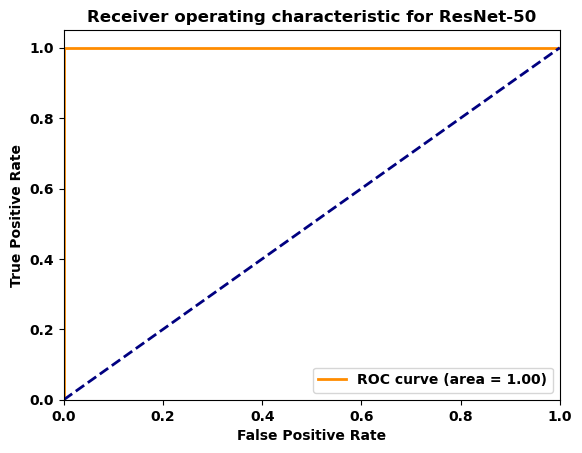

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
resnet50_model.evaluate(validation_set)



STEP_SIZE_TEST=validation_set.n//validation_set.batch_size
validation_set.reset()
preds=resnet50_model.predict(validation_set)
preds
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fpr, tpr, _ = roc_curve(validation_set.classes,  preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for ResNet-50',fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('Rocresnet50.png')
plt.show()

In [14]:

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

model = Sequential()
model.add(Conv2D(input_shape=(300,300,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [15]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [16]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 300, 300, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 150, 150, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                  

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size=32
steps_per_epoch = len(training_set)//batch_size

validation_steps = len(validation_set)//batch_size # if you have validation data 
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=len(training_set),generator=training_set, validation_data= validation_set,epochs=100,callbacks=[checkpoint,early])

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.8258 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.48602, saving model to vgg16_1.h5
81/81 [==============================] - 99s 1s/step - loss: 0.8258 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4860
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.5194
Epoch 2: val_accuracy improved from 0.48602 to 0.51398, saving model to vgg16_1.h5
81/81 [==============================] - 83s 1s/step - loss: 0.7155 - accuracy: 0.5194 - val_loss: 0.6928 - val_accuracy: 0.5140
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.5093
Epoch 3: val_accuracy did not improve from 0.51398
81/81 [==============================] - 78s 954ms/step - loss: 1.0579 - accuracy: 0.5093 - val_loss: 0.6929 - val_accuracy: 0.5140
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5140
Epoch 4: val_acc

Found 3224 images belonging to 2 classes.


Using optimizer: Adam, Epoch: 20
Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 1.3827 - main_loss: 1.1545 - aux1_loss: 0.4153 - aux2_loss: 0.3453 - main_accuracy: 0.8143 - aux1_accuracy: 0.8593 - aux2_accuracy: 0.8357WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 75s 844ms/step - loss: 1.3827 - main_loss: 1.1545 - aux1_loss: 0.4153 - aux2_loss: 0.3453 - main_accuracy: 0.8143 - aux1_accuracy: 0.8593 - aux2_accuracy: 0.8357
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.1459 - main_loss: 0.1008 - aux1_loss: 0.0686 - aux2_loss: 0.0819 - main_accuracy: 0.9605 - aux1_accuracy: 0.9748 - aux2_accuracy: 0.9709WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 818ms/step - loss: 0.1459 - main_loss: 0.1008 - aux1_loss: 0.0686 - aux2_loss: 0.0819 - main_accuracy: 0.9605 - aux1_accuracy: 0.9748 - aux2_accuracy: 0.9709
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.1353 - main_loss: 0.0944 - aux1_loss: 0.0633 - aux2_loss: 0.0731 - main_accuracy: 0.9636 - aux1_accuracy: 0.9771 - aux2_accuracy: 0.9698WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 815ms/step - loss: 0.1353 - main_loss: 0.0944 - aux1_loss: 0.0633 - aux2_loss: 0.0731 - main_accuracy: 0.9636 - aux1_accuracy: 0.9771 - aux2_accuracy: 0.9698
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.1193 - main_loss: 0.0843 - aux1_loss: 0.0486 - aux2_loss: 0.0680 - main_accuracy: 0.9694 - aux1_accuracy: 0.9837 - aux2_accuracy: 0.9752WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 816ms/step - loss: 0.1193 - main_loss: 0.0843 - aux1_loss: 0.0486 - aux2_loss: 0.0680 - main_accuracy: 0.9694 - aux1_accuracy: 0.9837 - aux2_accuracy: 0.9752
Epoch 5/20
81/81 [==============================] - ETA: 0s - loss: 0.0746 - main_loss: 0.0513 - aux1_loss: 0.0312 - aux2_loss: 0.0463 - main_accuracy: 0.9837 - aux1_accuracy: 0.9899 - aux2_accuracy: 0.9857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0746 - main_loss: 0.0513 - aux1_loss: 0.0312 - aux2_loss: 0.0463 - main_accuracy: 0.9837 - aux1_accuracy: 0.9899 - aux2_accuracy: 0.9857
Epoch 6/20
81/81 [==============================] - ETA: 0s - loss: 0.0694 - main_loss: 0.0468 - aux1_loss: 0.0360 - aux2_loss: 0.0392 - main_accuracy: 0.9826 - aux1_accuracy: 0.9880 - aux2_accuracy: 0.9853WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0694 - main_loss: 0.0468 - aux1_loss: 0.0360 - aux2_loss: 0.0392 - main_accuracy: 0.9826 - aux1_accuracy: 0.9880 - aux2_accuracy: 0.9853
Epoch 7/20
81/81 [==============================] - ETA: 0s - loss: 0.0724 - main_loss: 0.0520 - aux1_loss: 0.0273 - aux2_loss: 0.0407 - main_accuracy: 0.9837 - aux1_accuracy: 0.9922 - aux2_accuracy: 0.9864WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 816ms/step - loss: 0.0724 - main_loss: 0.0520 - aux1_loss: 0.0273 - aux2_loss: 0.0407 - main_accuracy: 0.9837 - aux1_accuracy: 0.9922 - aux2_accuracy: 0.9864
Epoch 8/20
81/81 [==============================] - ETA: 0s - loss: 0.0524 - main_loss: 0.0349 - aux1_loss: 0.0277 - aux2_loss: 0.0305 - main_accuracy: 0.9868 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9888WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 814ms/step - loss: 0.0524 - main_loss: 0.0349 - aux1_loss: 0.0277 - aux2_loss: 0.0305 - main_accuracy: 0.9868 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9888
Epoch 9/20
81/81 [==============================] - ETA: 0s - loss: 0.1397 - main_loss: 0.1042 - aux1_loss: 0.0447 - aux2_loss: 0.0737 - main_accuracy: 0.9620 - aux1_accuracy: 0.9806 - aux2_accuracy: 0.9729WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 819ms/step - loss: 0.1397 - main_loss: 0.1042 - aux1_loss: 0.0447 - aux2_loss: 0.0737 - main_accuracy: 0.9620 - aux1_accuracy: 0.9806 - aux2_accuracy: 0.9729
Epoch 10/20
81/81 [==============================] - ETA: 0s - loss: 0.0577 - main_loss: 0.0386 - aux1_loss: 0.0308 - aux2_loss: 0.0330 - main_accuracy: 0.9845 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9872WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 814ms/step - loss: 0.0577 - main_loss: 0.0386 - aux1_loss: 0.0308 - aux2_loss: 0.0330 - main_accuracy: 0.9845 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9872
Epoch 11/20
81/81 [==============================] - ETA: 0s - loss: 0.0649 - main_loss: 0.0464 - aux1_loss: 0.0259 - aux2_loss: 0.0358 - main_accuracy: 0.9814 - aux1_accuracy: 0.9926 - aux2_accuracy: 0.9853WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 67s 822ms/step - loss: 0.0649 - main_loss: 0.0464 - aux1_loss: 0.0259 - aux2_loss: 0.0358 - main_accuracy: 0.9814 - aux1_accuracy: 0.9926 - aux2_accuracy: 0.9853
Epoch 12/20
81/81 [==============================] - ETA: 0s - loss: 0.0478 - main_loss: 0.0334 - aux1_loss: 0.0227 - aux2_loss: 0.0256 - main_accuracy: 0.9860 - aux1_accuracy: 0.9891 - aux2_accuracy: 0.9911WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0478 - main_loss: 0.0334 - aux1_loss: 0.0227 - aux2_loss: 0.0256 - main_accuracy: 0.9860 - aux1_accuracy: 0.9891 - aux2_accuracy: 0.9911
Epoch 13/20
81/81 [==============================] - ETA: 0s - loss: 0.0670 - main_loss: 0.0463 - aux1_loss: 0.0302 - aux2_loss: 0.0389 - main_accuracy: 0.9833 - aux1_accuracy: 0.9876 - aux2_accuracy: 0.9833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 818ms/step - loss: 0.0670 - main_loss: 0.0463 - aux1_loss: 0.0302 - aux2_loss: 0.0389 - main_accuracy: 0.9833 - aux1_accuracy: 0.9876 - aux2_accuracy: 0.9833
Epoch 14/20
81/81 [==============================] - ETA: 0s - loss: 0.0964 - main_loss: 0.0694 - aux1_loss: 0.0430 - aux2_loss: 0.0469 - main_accuracy: 0.9767 - aux1_accuracy: 0.9868 - aux2_accuracy: 0.9857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0964 - main_loss: 0.0694 - aux1_loss: 0.0430 - aux2_loss: 0.0469 - main_accuracy: 0.9767 - aux1_accuracy: 0.9868 - aux2_accuracy: 0.9857
Epoch 15/20
81/81 [==============================] - ETA: 0s - loss: 0.0666 - main_loss: 0.0474 - aux1_loss: 0.0277 - aux2_loss: 0.0364 - main_accuracy: 0.9833 - aux1_accuracy: 0.9891 - aux2_accuracy: 0.9872WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0666 - main_loss: 0.0474 - aux1_loss: 0.0277 - aux2_loss: 0.0364 - main_accuracy: 0.9833 - aux1_accuracy: 0.9891 - aux2_accuracy: 0.9872
Epoch 16/20
81/81 [==============================] - ETA: 0s - loss: 0.1649 - main_loss: 0.1208 - aux1_loss: 0.0544 - aux2_loss: 0.0925 - main_accuracy: 0.9624 - aux1_accuracy: 0.9810 - aux2_accuracy: 0.9717WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.1649 - main_loss: 0.1208 - aux1_loss: 0.0544 - aux2_loss: 0.0925 - main_accuracy: 0.9624 - aux1_accuracy: 0.9810 - aux2_accuracy: 0.9717
Epoch 17/20
81/81 [==============================] - ETA: 0s - loss: 0.0584 - main_loss: 0.0393 - aux1_loss: 0.0302 - aux2_loss: 0.0337 - main_accuracy: 0.9849 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9907WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0584 - main_loss: 0.0393 - aux1_loss: 0.0302 - aux2_loss: 0.0337 - main_accuracy: 0.9849 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9907
Epoch 18/20
81/81 [==============================] - ETA: 0s - loss: 0.1216 - main_loss: 0.0886 - aux1_loss: 0.0458 - aux2_loss: 0.0642 - main_accuracy: 0.9663 - aux1_accuracy: 0.9841 - aux2_accuracy: 0.9798WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.1216 - main_loss: 0.0886 - aux1_loss: 0.0458 - aux2_loss: 0.0642 - main_accuracy: 0.9663 - aux1_accuracy: 0.9841 - aux2_accuracy: 0.9798
Epoch 19/20
81/81 [==============================] - ETA: 0s - loss: 0.0910 - main_loss: 0.0620 - aux1_loss: 0.0520 - aux2_loss: 0.0447 - main_accuracy: 0.9787 - aux1_accuracy: 0.9826 - aux2_accuracy: 0.9806WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0910 - main_loss: 0.0620 - aux1_loss: 0.0520 - aux2_loss: 0.0447 - main_accuracy: 0.9787 - aux1_accuracy: 0.9826 - aux2_accuracy: 0.9806
Epoch 20/20
81/81 [==============================] - ETA: 0s - loss: 0.0434 - main_loss: 0.0270 - aux1_loss: 0.0298 - aux2_loss: 0.0249 - main_accuracy: 0.9888 - aux1_accuracy: 0.9919 - aux2_accuracy: 0.9915WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0434 - main_loss: 0.0270 - aux1_loss: 0.0298 - aux2_loss: 0.0249 - main_accuracy: 0.9888 - aux1_accuracy: 0.9919 - aux2_accuracy: 0.9915
Using optimizer: SGD, Epoch: 30
Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 0.0226 - main_loss: 0.0132 - aux1_loss: 0.0151 - aux2_loss: 0.0163 - main_accuracy: 0.9961 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 68s 812ms/step - loss: 0.0226 - main_loss: 0.0132 - aux1_loss: 0.0151 - aux2_loss: 0.0163 - main_accuracy: 0.9961 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9961
Epoch 2/30
81/81 [==============================] - ETA: 0s - loss: 0.0182 - main_loss: 0.0110 - aux1_loss: 0.0116 - aux2_loss: 0.0125 - main_accuracy: 0.9973 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0182 - main_loss: 0.0110 - aux1_loss: 0.0116 - aux2_loss: 0.0125 - main_accuracy: 0.9973 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9953
Epoch 3/30
81/81 [==============================] - ETA: 0s - loss: 0.0204 - main_loss: 0.0126 - aux1_loss: 0.0129 - aux2_loss: 0.0130 - main_accuracy: 0.9946 - aux1_accuracy: 0.9938 - aux2_accuracy: 0.9953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0204 - main_loss: 0.0126 - aux1_loss: 0.0129 - aux2_loss: 0.0130 - main_accuracy: 0.9946 - aux1_accuracy: 0.9938 - aux2_accuracy: 0.9953
Epoch 4/30
81/81 [==============================] - ETA: 0s - loss: 0.0292 - main_loss: 0.0175 - aux1_loss: 0.0187 - aux2_loss: 0.0203 - main_accuracy: 0.9938 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9934WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 67s 823ms/step - loss: 0.0292 - main_loss: 0.0175 - aux1_loss: 0.0187 - aux2_loss: 0.0203 - main_accuracy: 0.9938 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9934
Epoch 5/30
81/81 [==============================] - ETA: 0s - loss: 0.0179 - main_loss: 0.0105 - aux1_loss: 0.0121 - aux2_loss: 0.0126 - main_accuracy: 0.9957 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0179 - main_loss: 0.0105 - aux1_loss: 0.0121 - aux2_loss: 0.0126 - main_accuracy: 0.9957 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9965
Epoch 6/30
81/81 [==============================] - ETA: 0s - loss: 0.0189 - main_loss: 0.0115 - aux1_loss: 0.0126 - aux2_loss: 0.0119 - main_accuracy: 0.9953 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0189 - main_loss: 0.0115 - aux1_loss: 0.0126 - aux2_loss: 0.0119 - main_accuracy: 0.9953 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9961
Epoch 7/30
81/81 [==============================] - ETA: 0s - loss: 0.0131 - main_loss: 0.0075 - aux1_loss: 0.0096 - aux2_loss: 0.0092 - main_accuracy: 0.9973 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0131 - main_loss: 0.0075 - aux1_loss: 0.0096 - aux2_loss: 0.0092 - main_accuracy: 0.9973 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9969
Epoch 8/30
81/81 [==============================] - ETA: 0s - loss: 0.0149 - main_loss: 0.0083 - aux1_loss: 0.0118 - aux2_loss: 0.0102 - main_accuracy: 0.9965 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0149 - main_loss: 0.0083 - aux1_loss: 0.0118 - aux2_loss: 0.0102 - main_accuracy: 0.9965 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9969
Epoch 9/30
81/81 [==============================] - ETA: 0s - loss: 0.0124 - main_loss: 0.0074 - aux1_loss: 0.0087 - aux2_loss: 0.0080 - main_accuracy: 0.9977 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 814ms/step - loss: 0.0124 - main_loss: 0.0074 - aux1_loss: 0.0087 - aux2_loss: 0.0080 - main_accuracy: 0.9977 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9969
Epoch 10/30
81/81 [==============================] - ETA: 0s - loss: 0.0138 - main_loss: 0.0078 - aux1_loss: 0.0111 - aux2_loss: 0.0087 - main_accuracy: 0.9977 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0138 - main_loss: 0.0078 - aux1_loss: 0.0111 - aux2_loss: 0.0087 - main_accuracy: 0.9977 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9977
Epoch 11/30
81/81 [==============================] - ETA: 0s - loss: 0.0086 - main_loss: 0.0049 - aux1_loss: 0.0060 - aux2_loss: 0.0065 - main_accuracy: 0.9988 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0086 - main_loss: 0.0049 - aux1_loss: 0.0060 - aux2_loss: 0.0065 - main_accuracy: 0.9988 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9973
Epoch 12/30
81/81 [==============================] - ETA: 0s - loss: 0.0119 - main_loss: 0.0066 - aux1_loss: 0.0094 - aux2_loss: 0.0082 - main_accuracy: 0.9969 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 820ms/step - loss: 0.0119 - main_loss: 0.0066 - aux1_loss: 0.0094 - aux2_loss: 0.0082 - main_accuracy: 0.9969 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9969
Epoch 13/30
81/81 [==============================] - ETA: 0s - loss: 0.0159 - main_loss: 0.0101 - aux1_loss: 0.0099 - aux2_loss: 0.0096 - main_accuracy: 0.9953 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 816ms/step - loss: 0.0159 - main_loss: 0.0101 - aux1_loss: 0.0099 - aux2_loss: 0.0096 - main_accuracy: 0.9953 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9965
Epoch 14/30
81/81 [==============================] - ETA: 0s - loss: 0.0238 - main_loss: 0.0162 - aux1_loss: 0.0120 - aux2_loss: 0.0136 - main_accuracy: 0.9950 - aux1_accuracy: 0.9950 - aux2_accuracy: 0.9946WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 819ms/step - loss: 0.0238 - main_loss: 0.0162 - aux1_loss: 0.0120 - aux2_loss: 0.0136 - main_accuracy: 0.9950 - aux1_accuracy: 0.9950 - aux2_accuracy: 0.9946
Epoch 15/30
81/81 [==============================] - ETA: 0s - loss: 0.0164 - main_loss: 0.0093 - aux1_loss: 0.0105 - aux2_loss: 0.0133 - main_accuracy: 0.9965 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9942WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0164 - main_loss: 0.0093 - aux1_loss: 0.0105 - aux2_loss: 0.0133 - main_accuracy: 0.9965 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9942
Epoch 16/30
81/81 [==============================] - ETA: 0s - loss: 0.0115 - main_loss: 0.0066 - aux1_loss: 0.0090 - aux2_loss: 0.0075 - main_accuracy: 0.9977 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0115 - main_loss: 0.0066 - aux1_loss: 0.0090 - aux2_loss: 0.0075 - main_accuracy: 0.9977 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9977
Epoch 17/30
81/81 [==============================] - ETA: 0s - loss: 0.0142 - main_loss: 0.0082 - aux1_loss: 0.0109 - aux2_loss: 0.0092 - main_accuracy: 0.9969 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 820ms/step - loss: 0.0142 - main_loss: 0.0082 - aux1_loss: 0.0109 - aux2_loss: 0.0092 - main_accuracy: 0.9969 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9969
Epoch 18/30
81/81 [==============================] - ETA: 0s - loss: 0.0147 - main_loss: 0.0089 - aux1_loss: 0.0104 - aux2_loss: 0.0091 - main_accuracy: 0.9961 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 810ms/step - loss: 0.0147 - main_loss: 0.0089 - aux1_loss: 0.0104 - aux2_loss: 0.0091 - main_accuracy: 0.9961 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9969
Epoch 19/30
81/81 [==============================] - ETA: 0s - loss: 0.0081 - main_loss: 0.0047 - aux1_loss: 0.0059 - aux2_loss: 0.0054 - main_accuracy: 0.9981 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0081 - main_loss: 0.0047 - aux1_loss: 0.0059 - aux2_loss: 0.0054 - main_accuracy: 0.9981 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9988
Epoch 20/30
81/81 [==============================] - ETA: 0s - loss: 0.0101 - main_loss: 0.0054 - aux1_loss: 0.0093 - aux2_loss: 0.0065 - main_accuracy: 0.9984 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 67s 823ms/step - loss: 0.0101 - main_loss: 0.0054 - aux1_loss: 0.0093 - aux2_loss: 0.0065 - main_accuracy: 0.9984 - aux1_accuracy: 0.9965 - aux2_accuracy: 0.9973
Epoch 21/30
81/81 [==============================] - ETA: 0s - loss: 0.0107 - main_loss: 0.0064 - aux1_loss: 0.0066 - aux2_loss: 0.0076 - main_accuracy: 0.9969 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0107 - main_loss: 0.0064 - aux1_loss: 0.0066 - aux2_loss: 0.0076 - main_accuracy: 0.9969 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9965
Epoch 22/30
81/81 [==============================] - ETA: 0s - loss: 0.0105 - main_loss: 0.0062 - aux1_loss: 0.0069 - aux2_loss: 0.0075 - main_accuracy: 0.9973 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0105 - main_loss: 0.0062 - aux1_loss: 0.0069 - aux2_loss: 0.0075 - main_accuracy: 0.9973 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9969
Epoch 23/30
81/81 [==============================] - ETA: 0s - loss: 0.0069 - main_loss: 0.0040 - aux1_loss: 0.0055 - aux2_loss: 0.0042 - main_accuracy: 0.9988 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 807ms/step - loss: 0.0069 - main_loss: 0.0040 - aux1_loss: 0.0055 - aux2_loss: 0.0042 - main_accuracy: 0.9988 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9992
Epoch 24/30
81/81 [==============================] - ETA: 0s - loss: 0.0065 - main_loss: 0.0032 - aux1_loss: 0.0063 - aux2_loss: 0.0048 - main_accuracy: 0.9984 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 815ms/step - loss: 0.0065 - main_loss: 0.0032 - aux1_loss: 0.0063 - aux2_loss: 0.0048 - main_accuracy: 0.9984 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9984
Epoch 25/30
81/81 [==============================] - ETA: 0s - loss: 0.0057 - main_loss: 0.0031 - aux1_loss: 0.0044 - aux2_loss: 0.0042 - main_accuracy: 0.9996 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0057 - main_loss: 0.0031 - aux1_loss: 0.0044 - aux2_loss: 0.0042 - main_accuracy: 0.9996 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9996
Epoch 26/30
81/81 [==============================] - ETA: 0s - loss: 0.0109 - main_loss: 0.0061 - aux1_loss: 0.0094 - aux2_loss: 0.0069 - main_accuracy: 0.9977 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0109 - main_loss: 0.0061 - aux1_loss: 0.0094 - aux2_loss: 0.0069 - main_accuracy: 0.9977 - aux1_accuracy: 0.9969 - aux2_accuracy: 0.9965
Epoch 27/30
81/81 [==============================] - ETA: 0s - loss: 0.0045 - main_loss: 0.0020 - aux1_loss: 0.0034 - aux2_loss: 0.0051 - main_accuracy: 0.9996 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0045 - main_loss: 0.0020 - aux1_loss: 0.0034 - aux2_loss: 0.0051 - main_accuracy: 0.9996 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9984
Epoch 28/30
81/81 [==============================] - ETA: 0s - loss: 0.0103 - main_loss: 0.0064 - aux1_loss: 0.0069 - aux2_loss: 0.0064 - main_accuracy: 0.9981 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0103 - main_loss: 0.0064 - aux1_loss: 0.0069 - aux2_loss: 0.0064 - main_accuracy: 0.9981 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9973
Epoch 29/30
81/81 [==============================] - ETA: 0s - loss: 0.0061 - main_loss: 0.0034 - aux1_loss: 0.0047 - aux2_loss: 0.0046 - main_accuracy: 0.9992 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 815ms/step - loss: 0.0061 - main_loss: 0.0034 - aux1_loss: 0.0047 - aux2_loss: 0.0046 - main_accuracy: 0.9992 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9977
Epoch 30/30
81/81 [==============================] - ETA: 0s - loss: 0.0058 - main_loss: 0.0029 - aux1_loss: 0.0050 - aux2_loss: 0.0046 - main_accuracy: 0.9996 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0058 - main_loss: 0.0029 - aux1_loss: 0.0050 - aux2_loss: 0.0046 - main_accuracy: 0.9996 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9984
Using optimizer: Adam, Epoch: 20
Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.1354 - main_loss: 0.0990 - aux1_loss: 0.0577 - aux2_loss: 0.0636 - main_accuracy: 0.9744 - aux1_accuracy: 0.9829 - aux2_accuracy: 0.9814WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 68s 808ms/step - loss: 0.1354 - main_loss: 0.0990 - aux1_loss: 0.0577 - aux2_loss: 0.0636 - main_accuracy: 0.9744 - aux1_accuracy: 0.9829 - aux2_accuracy: 0.9814
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.0349 - main_loss: 0.0217 - aux1_loss: 0.0210 - aux2_loss: 0.0228 - main_accuracy: 0.9922 - aux1_accuracy: 0.9919 - aux2_accuracy: 0.9934WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 815ms/step - loss: 0.0349 - main_loss: 0.0217 - aux1_loss: 0.0210 - aux2_loss: 0.0228 - main_accuracy: 0.9922 - aux1_accuracy: 0.9919 - aux2_accuracy: 0.9934
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.0227 - main_loss: 0.0142 - aux1_loss: 0.0173 - aux2_loss: 0.0108 - main_accuracy: 0.9934 - aux1_accuracy: 0.9934 - aux2_accuracy: 0.9957WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0227 - main_loss: 0.0142 - aux1_loss: 0.0173 - aux2_loss: 0.0108 - main_accuracy: 0.9934 - aux1_accuracy: 0.9934 - aux2_accuracy: 0.9957
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.0405 - main_loss: 0.0281 - aux1_loss: 0.0210 - aux2_loss: 0.0201 - main_accuracy: 0.9930 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 810ms/step - loss: 0.0405 - main_loss: 0.0281 - aux1_loss: 0.0210 - aux2_loss: 0.0201 - main_accuracy: 0.9930 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9938
Epoch 5/20
81/81 [==============================] - ETA: 0s - loss: 0.0345 - main_loss: 0.0252 - aux1_loss: 0.0155 - aux2_loss: 0.0155 - main_accuracy: 0.9899 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0345 - main_loss: 0.0252 - aux1_loss: 0.0155 - aux2_loss: 0.0155 - main_accuracy: 0.9899 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9938
Epoch 6/20
81/81 [==============================] - ETA: 0s - loss: 0.0225 - main_loss: 0.0147 - aux1_loss: 0.0156 - aux2_loss: 0.0106 - main_accuracy: 0.9950 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0225 - main_loss: 0.0147 - aux1_loss: 0.0156 - aux2_loss: 0.0106 - main_accuracy: 0.9950 - aux1_accuracy: 0.9961 - aux2_accuracy: 0.9961
Epoch 7/20
81/81 [==============================] - ETA: 0s - loss: 0.0445 - main_loss: 0.0310 - aux1_loss: 0.0273 - aux2_loss: 0.0176 - main_accuracy: 0.9864 - aux1_accuracy: 0.9915 - aux2_accuracy: 0.9926WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 807ms/step - loss: 0.0445 - main_loss: 0.0310 - aux1_loss: 0.0273 - aux2_loss: 0.0176 - main_accuracy: 0.9864 - aux1_accuracy: 0.9915 - aux2_accuracy: 0.9926
Epoch 8/20
81/81 [==============================] - ETA: 0s - loss: 0.4814 - main_loss: 0.3876 - aux1_loss: 0.1274 - aux2_loss: 0.1853 - main_accuracy: 0.9248 - aux1_accuracy: 0.9713 - aux2_accuracy: 0.9570WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 807ms/step - loss: 0.4814 - main_loss: 0.3876 - aux1_loss: 0.1274 - aux2_loss: 0.1853 - main_accuracy: 0.9248 - aux1_accuracy: 0.9713 - aux2_accuracy: 0.9570
Epoch 9/20
81/81 [==============================] - ETA: 0s - loss: 0.0621 - main_loss: 0.0426 - aux1_loss: 0.0354 - aux2_loss: 0.0296 - main_accuracy: 0.9818 - aux1_accuracy: 0.9864 - aux2_accuracy: 0.9872WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 67s 830ms/step - loss: 0.0621 - main_loss: 0.0426 - aux1_loss: 0.0354 - aux2_loss: 0.0296 - main_accuracy: 0.9818 - aux1_accuracy: 0.9864 - aux2_accuracy: 0.9872
Epoch 10/20
81/81 [==============================] - ETA: 0s - loss: 0.0384 - main_loss: 0.0240 - aux1_loss: 0.0278 - aux2_loss: 0.0202 - main_accuracy: 0.9895 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9919WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 71s 873ms/step - loss: 0.0384 - main_loss: 0.0240 - aux1_loss: 0.0278 - aux2_loss: 0.0202 - main_accuracy: 0.9895 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9919
Epoch 11/20
81/81 [==============================] - ETA: 0s - loss: 0.0364 - main_loss: 0.0204 - aux1_loss: 0.0368 - aux2_loss: 0.0163 - main_accuracy: 0.9919 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9946WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0364 - main_loss: 0.0204 - aux1_loss: 0.0368 - aux2_loss: 0.0163 - main_accuracy: 0.9919 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9946
Epoch 12/20
81/81 [==============================] - ETA: 0s - loss: 0.0214 - main_loss: 0.0139 - aux1_loss: 0.0132 - aux2_loss: 0.0121 - main_accuracy: 0.9946 - aux1_accuracy: 0.9950 - aux2_accuracy: 0.9953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 815ms/step - loss: 0.0214 - main_loss: 0.0139 - aux1_loss: 0.0132 - aux2_loss: 0.0121 - main_accuracy: 0.9946 - aux1_accuracy: 0.9950 - aux2_accuracy: 0.9953
Epoch 13/20
81/81 [==============================] - ETA: 0s - loss: 0.0358 - main_loss: 0.0244 - aux1_loss: 0.0165 - aux2_loss: 0.0216 - main_accuracy: 0.9934 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0358 - main_loss: 0.0244 - aux1_loss: 0.0165 - aux2_loss: 0.0216 - main_accuracy: 0.9934 - aux1_accuracy: 0.9946 - aux2_accuracy: 0.9930
Epoch 14/20
81/81 [==============================] - ETA: 0s - loss: 0.0235 - main_loss: 0.0156 - aux1_loss: 0.0142 - aux2_loss: 0.0122 - main_accuracy: 0.9957 - aux1_accuracy: 0.9957 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 808ms/step - loss: 0.0235 - main_loss: 0.0156 - aux1_loss: 0.0142 - aux2_loss: 0.0122 - main_accuracy: 0.9957 - aux1_accuracy: 0.9957 - aux2_accuracy: 0.9969
Epoch 15/20
81/81 [==============================] - ETA: 0s - loss: 0.0149 - main_loss: 0.0101 - aux1_loss: 0.0081 - aux2_loss: 0.0078 - main_accuracy: 0.9977 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9981WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0149 - main_loss: 0.0101 - aux1_loss: 0.0081 - aux2_loss: 0.0078 - main_accuracy: 0.9977 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9981
Epoch 16/20
81/81 [==============================] - ETA: 0s - loss: 0.0346 - main_loss: 0.0236 - aux1_loss: 0.0152 - aux2_loss: 0.0216 - main_accuracy: 0.9922 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0346 - main_loss: 0.0236 - aux1_loss: 0.0152 - aux2_loss: 0.0216 - main_accuracy: 0.9922 - aux1_accuracy: 0.9953 - aux2_accuracy: 0.9930
Epoch 17/20
81/81 [==============================] - ETA: 0s - loss: 0.0229 - main_loss: 0.0133 - aux1_loss: 0.0183 - aux2_loss: 0.0137 - main_accuracy: 0.9950 - aux1_accuracy: 0.9957 - aux2_accuracy: 0.9950WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0229 - main_loss: 0.0133 - aux1_loss: 0.0183 - aux2_loss: 0.0137 - main_accuracy: 0.9950 - aux1_accuracy: 0.9957 - aux2_accuracy: 0.9950
Epoch 18/20
81/81 [==============================] - ETA: 0s - loss: 0.0118 - main_loss: 0.0083 - aux1_loss: 0.0060 - aux2_loss: 0.0056 - main_accuracy: 0.9981 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 814ms/step - loss: 0.0118 - main_loss: 0.0083 - aux1_loss: 0.0060 - aux2_loss: 0.0056 - main_accuracy: 0.9981 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9988
Epoch 19/20
81/81 [==============================] - ETA: 0s - loss: 0.0174 - main_loss: 0.0123 - aux1_loss: 0.0071 - aux2_loss: 0.0099 - main_accuracy: 0.9942 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0174 - main_loss: 0.0123 - aux1_loss: 0.0071 - aux2_loss: 0.0099 - main_accuracy: 0.9942 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9965
Epoch 20/20
81/81 [==============================] - ETA: 0s - loss: 0.0524 - main_loss: 0.0357 - aux1_loss: 0.0299 - aux2_loss: 0.0256 - main_accuracy: 0.9907 - aux1_accuracy: 0.9919 - aux2_accuracy: 0.9926WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0524 - main_loss: 0.0357 - aux1_loss: 0.0299 - aux2_loss: 0.0256 - main_accuracy: 0.9907 - aux1_accuracy: 0.9919 - aux2_accuracy: 0.9926
Using optimizer: SGD, Epoch: 30
Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 0.0196 - main_loss: 0.0115 - aux1_loss: 0.0160 - aux2_loss: 0.0109 - main_accuracy: 0.9965 - aux1_accuracy: 0.9930 - aux2_accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 67s 808ms/step - loss: 0.0196 - main_loss: 0.0115 - aux1_loss: 0.0160 - aux2_loss: 0.0109 - main_accuracy: 0.9965 - aux1_accuracy: 0.9930 - aux2_accuracy: 0.9961
Epoch 2/30
81/81 [==============================] - ETA: 0s - loss: 0.0124 - main_loss: 0.0072 - aux1_loss: 0.0088 - aux2_loss: 0.0086 - main_accuracy: 0.9984 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 806ms/step - loss: 0.0124 - main_loss: 0.0072 - aux1_loss: 0.0088 - aux2_loss: 0.0086 - main_accuracy: 0.9984 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9977
Epoch 3/30
81/81 [==============================] - ETA: 0s - loss: 0.0114 - main_loss: 0.0065 - aux1_loss: 0.0073 - aux2_loss: 0.0088 - main_accuracy: 0.9969 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 808ms/step - loss: 0.0114 - main_loss: 0.0065 - aux1_loss: 0.0073 - aux2_loss: 0.0088 - main_accuracy: 0.9969 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9969
Epoch 4/30
81/81 [==============================] - ETA: 0s - loss: 0.0058 - main_loss: 0.0033 - aux1_loss: 0.0036 - aux2_loss: 0.0048 - main_accuracy: 0.9992 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0058 - main_loss: 0.0033 - aux1_loss: 0.0036 - aux2_loss: 0.0048 - main_accuracy: 0.9992 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9992
Epoch 5/30
81/81 [==============================] - ETA: 0s - loss: 0.0076 - main_loss: 0.0037 - aux1_loss: 0.0073 - aux2_loss: 0.0057 - main_accuracy: 0.9988 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 814ms/step - loss: 0.0076 - main_loss: 0.0037 - aux1_loss: 0.0073 - aux2_loss: 0.0057 - main_accuracy: 0.9988 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9977
Epoch 6/30
81/81 [==============================] - ETA: 0s - loss: 0.0068 - main_loss: 0.0041 - aux1_loss: 0.0046 - aux2_loss: 0.0045 - main_accuracy: 0.9996 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0068 - main_loss: 0.0041 - aux1_loss: 0.0046 - aux2_loss: 0.0045 - main_accuracy: 0.9996 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9988
Epoch 7/30
81/81 [==============================] - ETA: 0s - loss: 0.0037 - main_loss: 0.0016 - aux1_loss: 0.0036 - aux2_loss: 0.0035 - main_accuracy: 0.9996 - aux1_accuracy: 0.9996 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 808ms/step - loss: 0.0037 - main_loss: 0.0016 - aux1_loss: 0.0036 - aux2_loss: 0.0035 - main_accuracy: 0.9996 - aux1_accuracy: 0.9996 - aux2_accuracy: 0.9988
Epoch 8/30
81/81 [==============================] - ETA: 0s - loss: 0.0109 - main_loss: 0.0067 - aux1_loss: 0.0066 - aux2_loss: 0.0075 - main_accuracy: 0.9977 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 67s 820ms/step - loss: 0.0109 - main_loss: 0.0067 - aux1_loss: 0.0066 - aux2_loss: 0.0075 - main_accuracy: 0.9977 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9977
Epoch 9/30
81/81 [==============================] - ETA: 0s - loss: 0.0040 - main_loss: 0.0024 - aux1_loss: 0.0019 - aux2_loss: 0.0032 - main_accuracy: 0.9992 - aux1_accuracy: 1.0000 - aux2_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 808ms/step - loss: 0.0040 - main_loss: 0.0024 - aux1_loss: 0.0019 - aux2_loss: 0.0032 - main_accuracy: 0.9992 - aux1_accuracy: 1.0000 - aux2_accuracy: 0.9992
Epoch 10/30
81/81 [==============================] - ETA: 0s - loss: 0.0040 - main_loss: 0.0019 - aux1_loss: 0.0040 - aux2_loss: 0.0030 - main_accuracy: 0.9992 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0040 - main_loss: 0.0019 - aux1_loss: 0.0040 - aux2_loss: 0.0030 - main_accuracy: 0.9992 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9988
Epoch 11/30
81/81 [==============================] - ETA: 0s - loss: 0.0065 - main_loss: 0.0043 - aux1_loss: 0.0036 - aux2_loss: 0.0037 - main_accuracy: 0.9984 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 810ms/step - loss: 0.0065 - main_loss: 0.0043 - aux1_loss: 0.0036 - aux2_loss: 0.0037 - main_accuracy: 0.9984 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9996
Epoch 12/30
81/81 [==============================] - ETA: 0s - loss: 0.0036 - main_loss: 0.0016 - aux1_loss: 0.0038 - aux2_loss: 0.0030 - main_accuracy: 0.9996 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 808ms/step - loss: 0.0036 - main_loss: 0.0016 - aux1_loss: 0.0038 - aux2_loss: 0.0030 - main_accuracy: 0.9996 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9996
Epoch 13/30
81/81 [==============================] - ETA: 0s - loss: 0.0085 - main_loss: 0.0058 - aux1_loss: 0.0040 - aux2_loss: 0.0049 - main_accuracy: 0.9973 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 814ms/step - loss: 0.0085 - main_loss: 0.0058 - aux1_loss: 0.0040 - aux2_loss: 0.0049 - main_accuracy: 0.9973 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9977
Epoch 14/30
81/81 [==============================] - ETA: 0s - loss: 0.0056 - main_loss: 0.0033 - aux1_loss: 0.0046 - aux2_loss: 0.0029 - main_accuracy: 0.9988 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 806ms/step - loss: 0.0056 - main_loss: 0.0033 - aux1_loss: 0.0046 - aux2_loss: 0.0029 - main_accuracy: 0.9988 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9992
Epoch 15/30
81/81 [==============================] - ETA: 0s - loss: 0.0058 - main_loss: 0.0037 - aux1_loss: 0.0031 - aux2_loss: 0.0039 - main_accuracy: 0.9988 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0058 - main_loss: 0.0037 - aux1_loss: 0.0031 - aux2_loss: 0.0039 - main_accuracy: 0.9988 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9988
Epoch 16/30
81/81 [==============================] - ETA: 0s - loss: 0.0098 - main_loss: 0.0053 - aux1_loss: 0.0086 - aux2_loss: 0.0065 - main_accuracy: 0.9977 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0098 - main_loss: 0.0053 - aux1_loss: 0.0086 - aux2_loss: 0.0065 - main_accuracy: 0.9977 - aux1_accuracy: 0.9977 - aux2_accuracy: 0.9973
Epoch 17/30
81/81 [==============================] - ETA: 0s - loss: 0.0048 - main_loss: 0.0019 - aux1_loss: 0.0053 - aux2_loss: 0.0040 - main_accuracy: 0.9984 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9981WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0048 - main_loss: 0.0019 - aux1_loss: 0.0053 - aux2_loss: 0.0040 - main_accuracy: 0.9984 - aux1_accuracy: 0.9973 - aux2_accuracy: 0.9981
Epoch 18/30
81/81 [==============================] - ETA: 0s - loss: 0.0047 - main_loss: 0.0021 - aux1_loss: 0.0052 - aux2_loss: 0.0035 - main_accuracy: 0.9996 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0047 - main_loss: 0.0021 - aux1_loss: 0.0052 - aux2_loss: 0.0035 - main_accuracy: 0.9996 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9988
Epoch 19/30
81/81 [==============================] - ETA: 0s - loss: 0.0044 - main_loss: 0.0023 - aux1_loss: 0.0040 - aux2_loss: 0.0029 - main_accuracy: 0.9996 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 809ms/step - loss: 0.0044 - main_loss: 0.0023 - aux1_loss: 0.0040 - aux2_loss: 0.0029 - main_accuracy: 0.9996 - aux1_accuracy: 0.9984 - aux2_accuracy: 0.9988
Epoch 20/30
81/81 [==============================] - ETA: 0s - loss: 0.0019 - main_loss: 8.9262e-04 - aux1_loss: 0.0019 - aux2_loss: 0.0015 - main_accuracy: 1.0000 - aux1_accuracy: 0.9996 - aux2_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 820ms/step - loss: 0.0019 - main_loss: 8.9262e-04 - aux1_loss: 0.0019 - aux2_loss: 0.0015 - main_accuracy: 1.0000 - aux1_accuracy: 0.9996 - aux2_accuracy: 1.0000
Epoch 21/30
81/81 [==============================] - ETA: 0s - loss: 0.0028 - main_loss: 0.0016 - aux1_loss: 0.0021 - aux2_loss: 0.0019 - main_accuracy: 0.9996 - aux1_accuracy: 0.9996 - aux2_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 807ms/step - loss: 0.0028 - main_loss: 0.0016 - aux1_loss: 0.0021 - aux2_loss: 0.0019 - main_accuracy: 0.9996 - aux1_accuracy: 0.9996 - aux2_accuracy: 1.0000
Epoch 22/30
81/81 [==============================] - ETA: 0s - loss: 0.0030 - main_loss: 0.0014 - aux1_loss: 0.0032 - aux2_loss: 0.0022 - main_accuracy: 1.0000 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 808ms/step - loss: 0.0030 - main_loss: 0.0014 - aux1_loss: 0.0032 - aux2_loss: 0.0022 - main_accuracy: 1.0000 - aux1_accuracy: 0.9988 - aux2_accuracy: 0.9996
Epoch 23/30
81/81 [==============================] - ETA: 0s - loss: 0.0060 - main_loss: 0.0034 - aux1_loss: 0.0057 - aux2_loss: 0.0031 - main_accuracy: 0.9988 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 807ms/step - loss: 0.0060 - main_loss: 0.0034 - aux1_loss: 0.0057 - aux2_loss: 0.0031 - main_accuracy: 0.9988 - aux1_accuracy: 0.9981 - aux2_accuracy: 0.9984
Epoch 24/30
81/81 [==============================] - ETA: 0s - loss: 0.0014 - main_loss: 5.7961e-04 - aux1_loss: 0.0018 - aux2_loss: 0.0010 - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 820ms/step - loss: 0.0014 - main_loss: 5.7961e-04 - aux1_loss: 0.0018 - aux2_loss: 0.0010 - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 1.0000
Epoch 25/30
81/81 [==============================] - ETA: 0s - loss: 0.0032 - main_loss: 0.0018 - aux1_loss: 0.0022 - aux2_loss: 0.0027 - main_accuracy: 0.9992 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 812ms/step - loss: 0.0032 - main_loss: 0.0018 - aux1_loss: 0.0022 - aux2_loss: 0.0027 - main_accuracy: 0.9992 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9992
Epoch 26/30
81/81 [==============================] - ETA: 0s - loss: 0.0023 - main_loss: 0.0012 - aux1_loss: 0.0019 - aux2_loss: 0.0018 - main_accuracy: 0.9996 - aux1_accuracy: 0.9996 - aux2_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 813ms/step - loss: 0.0023 - main_loss: 0.0012 - aux1_loss: 0.0019 - aux2_loss: 0.0018 - main_accuracy: 0.9996 - aux1_accuracy: 0.9996 - aux2_accuracy: 0.9996
Epoch 27/30
81/81 [==============================] - ETA: 0s - loss: 0.0014 - main_loss: 4.1364e-04 - aux1_loss: 0.0015 - aux2_loss: 0.0018 - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 807ms/step - loss: 0.0014 - main_loss: 4.1364e-04 - aux1_loss: 0.0015 - aux2_loss: 0.0018 - main_accuracy: 1.0000 - aux1_accuracy: 1.0000 - aux2_accuracy: 0.9996
Epoch 28/30
81/81 [==============================] - ETA: 0s - loss: 0.0028 - main_loss: 0.0012 - aux1_loss: 0.0026 - aux2_loss: 0.0026 - main_accuracy: 0.9992 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0028 - main_loss: 0.0012 - aux1_loss: 0.0026 - aux2_loss: 0.0026 - main_accuracy: 0.9992 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9992
Epoch 29/30
81/81 [==============================] - ETA: 0s - loss: 0.0016 - main_loss: 5.9649e-04 - aux1_loss: 0.0019 - aux2_loss: 0.0014 - main_accuracy: 1.0000 - aux1_accuracy: 0.9996 - aux2_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 66s 811ms/step - loss: 0.0016 - main_loss: 5.9649e-04 - aux1_loss: 0.0019 - aux2_loss: 0.0014 - main_accuracy: 1.0000 - aux1_accuracy: 0.9996 - aux2_accuracy: 1.0000
Epoch 30/30
81/81 [==============================] - ETA: 0s - loss: 0.0033 - main_loss: 0.0019 - aux1_loss: 0.0024 - aux2_loss: 0.0024 - main_accuracy: 0.9996 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9988 WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


81/81 [==============================] - 65s 806ms/step - loss: 0.0033 - main_loss: 0.0019 - aux1_loss: 0.0024 - aux2_loss: 0.0024 - main_accuracy: 0.9996 - aux1_accuracy: 0.9992 - aux2_accuracy: 0.9988


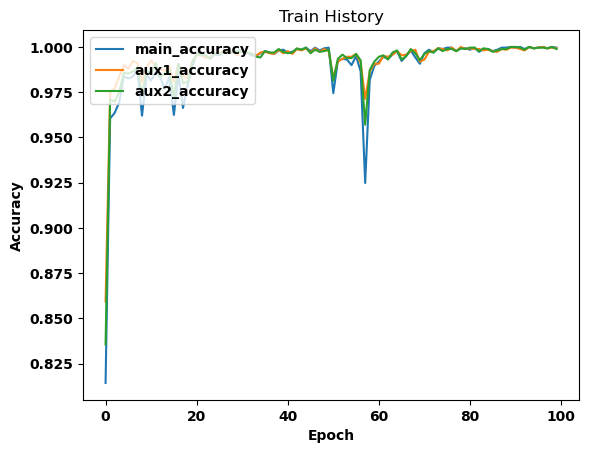

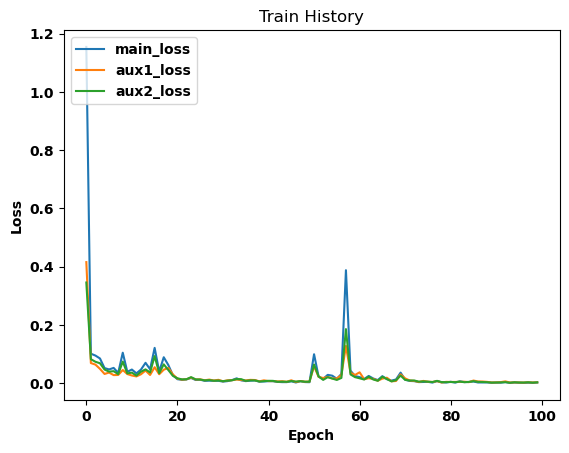

In [18]:


import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
IMAGE_SHAPE = (300, 300, 3)
CLASS_NUM = 2
BATCH_SIZE = 16
EPOCH_STEPS = int(4323/BATCH_SIZE)


MODEL_NAME = 'googlenet_flower.h5'
generator_main = train_datagen.flow_from_directory(
    '/work/networks/sriram88/DATA',
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

def my_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

train_generator = my_generator(generator_main)

# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


# train model
model = googlenet()
# model.summary()
#model.load_weights(MODEL_NAME)
#tf.keras.utils.plot_model(model, 'GoogLeNet.png')

#optimizer = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}
checkpoint = ModelCheckpoint("googlenet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
for i in range(len(optimizer)):
    print('Using optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit_generator(
            training_set,
            steps_per_epoch=len(training_set),
            epochs=epochs[i],
            #callbacks=[checkpoint]
            callbacks=[checkpoint,early],
            shuffle=True
            )
    
    # save history    
    if len(history_all) == 0:
        history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
        history_all[key].extend(train_history.history[key])

model.save(MODEL_NAME)

# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))


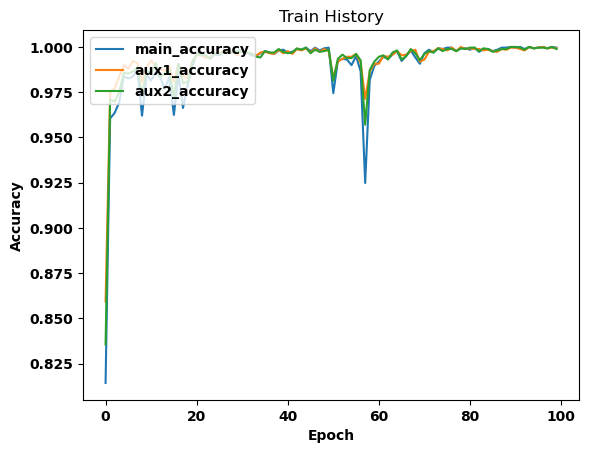

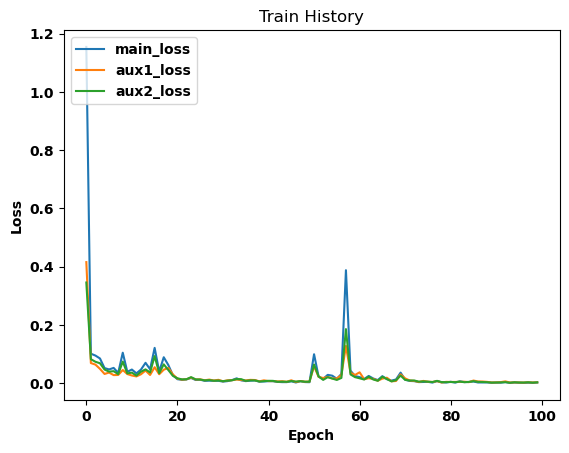

In [25]:
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))

21/21 [==============================] - 11s 507ms/step


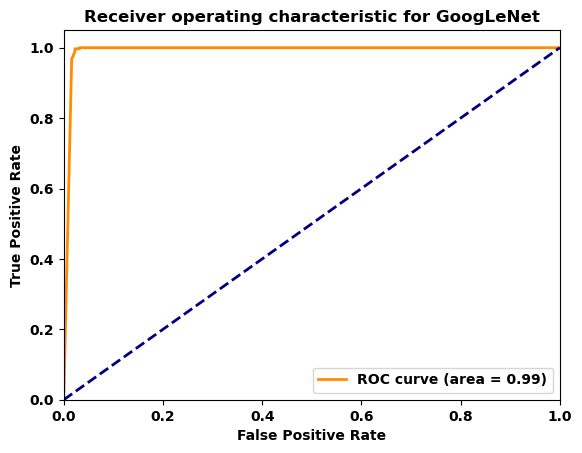

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
model.evaluate(validation_set)



STEP_SIZE_TEST=validation_set.n//validation_set.batch_size
validation_set.reset()
preds=model.predict(validation_set)
preds

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure()
lw = 2
fpr, tpr, _ = roc_curve(validation_set.classes,  preds[0][:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for GoogLeNet',fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('Googlenetroc.png')
plt.show()


In [21]:
preds[1][:,1]

array([9.64221239e-01, 2.66265143e-02, 9.98910189e-01, 6.02607476e-03,
       1.59462672e-06, 7.25496357e-05, 1.79704301e-07, 3.18899538e-07,
       4.21853201e-08, 9.05703843e-01, 9.85221446e-01, 9.14787412e-01,
       2.91789220e-05, 3.89303965e-03, 9.99523520e-01, 2.38072306e-01,
       4.51167762e-06, 1.44572596e-06, 1.93104945e-08, 3.82626183e-07,
       1.17480257e-08, 6.56644852e-06, 2.91576242e-07, 1.41680755e-06,
       1.85140987e-08, 9.99998569e-01, 1.33042874e-08, 3.34778065e-07,
       5.17923809e-07, 8.20765820e-07, 6.20797291e-05, 1.15355470e-09,
       7.32437820e-06, 3.01082963e-07, 1.68779096e-07, 2.98300584e-08,
       1.31213710e-01, 4.25695325e-05, 5.58649333e-07, 1.59940755e-04,
       1.42396107e-06, 4.34410794e-07, 2.43783695e-08, 1.43296637e-08,
       3.61442435e-05, 7.88668240e-06, 3.82831649e-06, 7.92233407e-01,
       3.59000722e-07, 6.88762384e-06, 1.36837742e-04, 3.40770138e-03,
       1.62092596e-02, 8.99840321e-04, 3.38507593e-01, 5.44362843e-01,
      

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_set)
y_pred = np.argmax(Y_pred[0], axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_set.classes, y_pred)
print('Classification Report')
target_names = ['NH4CL', 'Others']
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       NH4CL       1.00      0.90      0.95       313
      Others       0.91      1.00      0.96       331

    accuracy                           0.95       644
   macro avg       0.96      0.95      0.95       644
weighted avg       0.96      0.95      0.95       644



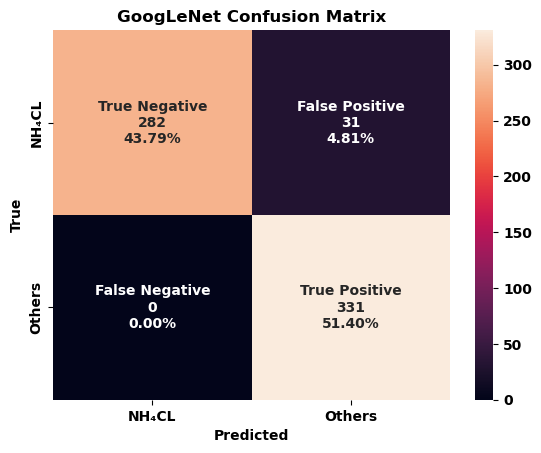

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
labels = ['NH\u2084CL', "Others",]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


# sns.heatmap(cm, annot=True)
# disp.plot(cmap=plt.cm.Blues)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.title('CNN Confusion Matrix')

# plt.savefig('cnn.png')

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
label=['NH\u2084CL', "Others",]
sns.heatmap(cm, annot=labels, fmt='',xticklabels=label, yticklabels=label)
plt.title('GoogLeNet Confusion Matrix',fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('googlenetconfusion.png')
plt.show()

In [24]:
roc_auc_score(validation_set.classes, preds[1][:,1])

0.9998262598573401